In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import pandas as pd
from torch.distributions.multivariate_normal import MultivariateNormal
import random 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import multivariate_normal
import math
import gpytorch 
import numpy as geek

In [2]:
# set data types for default
torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

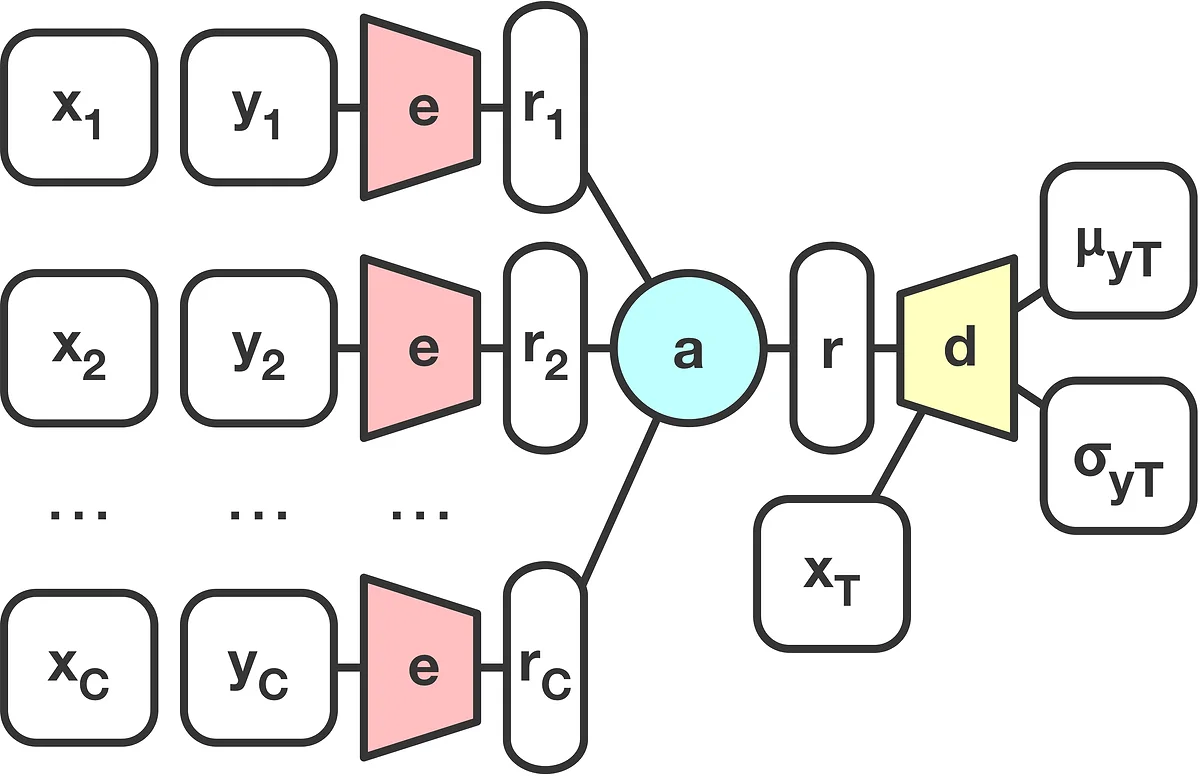

### Data generation and prepration 


In [3]:
# Generate real stocks data for training and testing
def generate_real_data(num_context, num_target , temp):
    df = pd.read_csv("AAPL_price.csv")
    df["ind_x"] = df.index.astype("float64")
    df = df[["ind_x" , "Close" ]]
#     duration = num_context+ num_target
    duration = 2
    context_x = torch.unsqueeze(torch.tensor(df.loc[temp*duration:num_context+temp*duration , :]["ind_x"].values) , 1)
    context_y = torch.unsqueeze(torch.tensor(df.loc[temp*duration:num_context+temp*duration , :]["Close"].values) , 1)
    target_x = torch.unsqueeze(torch.tensor(df.loc[num_context+temp*duration:num_target+num_context+temp*duration , :]["ind_x"].values) , 1)
    target_y = torch.unsqueeze(torch.tensor(df.loc[num_context+temp*duration:num_target+num_context+temp*duration , :]["Close"].values) , 1)
    
    return context_x, context_y, target_x, target_y




# Generate synthesis GP data for training and testing
class generate_GP_data:
    def __init__(self , sigma_scale , length_scale , L , U , num_context , num_target , upsample=10):
        
        self.n_func = 1
        self.L = L
        self.U = U
        self.sigma_scale = sigma_scale
        self.upsample = upsample 
        self.length_scale = length_scale
        self.num_context = num_context
        self.num_target = num_target
        self.n = self.upsample*(self.U-self.L)
        self.kernel = self.sigma_scale* RBF(self.length_scale)
        self.X = np.linspace(self.L, self.U, self.n).reshape(-1, 1)
        self.K = self.kernel(self.X)


        # parametize a multivariate Gaussian with zero mean and K as the covariance matrix
        # rvs : random variable sampling : Generate random samples from a multivariate normal.
        
        
        ##########################   dimension of mean = cov  !!!!! 
        self.ys = multivariate_normal.rvs(mean = np.zeros(self.n), 
                                     cov = self.K, 
                                     size = self.n_func)
        self.xs = np.arange(self.L , self.U , 1/self.upsample)
        
        self.context_x = random.sample(range(self.L , self.U-self.num_target), self.num_context)        
        self.context_y = self.ys[[(i-self.L)*self.upsample  for i in self.context_x]]
#         self.target_x = self.xs[-self.num_target*self.upsample:] 
#         self.target_y = self.ys[-self.num_target*self.upsample:] 
        
#         use all domain for target and prediction 
        self.target_x = self.xs
        self.target_y = self.ys
        
#         self.fig , self.ax = plt.subplots(1,1 , figsize=(10,4))
#         colors=["olivedrab" , "red" , "green" , "steelblue" , "orange" , "black" , "darkkhaki"]
#         self.ax.scatter(self.context_x , self.context_y)
# #         plot train zone 
#         self.ax.plot(self.xs[:-self.num_target*self.upsample] , self.ys[:-self.num_target*self.upsample] , color="olivedrab")
# #         plot target zone 
#         self.ax.plot(self.xs[-self.num_target*self.upsample:] , self.ys[-self.num_target*self.upsample:] , color="red")
# #         self.ax.plot(self.target_x, self.target_y , color="red")
#         self.ax.set_xticks(np.arange(self.L, self.U, 1))
#         self.ax.set_title(f"{self.n_func} samples from a Gaussian process prior")


    def give_data(self):
        return ( torch.unsqueeze(torch.tensor(self.context_x),1) , 
               torch.unsqueeze(torch.tensor(self.context_y) ,1) , 
               torch.unsqueeze(torch.tensor(self.target_x) ,1) ,
               torch.unsqueeze(torch.tensor(self.target_y),1) ,
               torch.unsqueeze(torch.tensor(self.ys),1) ,
               torch.unsqueeze(torch.tensor(self.xs),1))


In [4]:
GP = generate_GP_data( 1 ,0.4, 30 , 50 ,8 , 5)
x,y,xx,yy ,ys, xs= GP.give_data()
x.shape 

torch.Size([8, 1])

### Model structure 

In [5]:
# Define the Encoder network
class CNPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CNPEncoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim )
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x



# Define the Decoder network
class CNPDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim ):
        super(CNPDecoder, self).__init__()
        self.fc1 = nn.Linear(int(input_dim/2)+hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim )
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the Conditional Neural Process model
class CNP(nn.Module):
    def __init__(self, encoder, decoder):
        super(CNP, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, context_x, context_y, target_x ):
        # Encode the context pairs (context_x, context_y)
        context = torch.cat([context_x, context_y], dim=-1)
        rep = self.encoder(context)
        
        
        #aggregate the representations 
        aggregated = torch.mean(rep , 0)
        
            
        # Repeat the aggregated representation for each target point
        num_targets = target_x.size(0)
        aggregated = aggregated.unsqueeze(0).repeat(num_targets, 1)
        
        # Concatenate the target points with the aggregated representation
        target = torch.cat([target_x, aggregated], dim=-1)
        # i.e return  [10  ,   64+1 ]
        
        # Decode the target points
        target_y = self.decoder(target)
        
        return target_y
#      i.e. [10 , 2 ] 
    
  
        

### Train and Test 

In [6]:
# Define the training procedure
def train(model, optimizer, context_x, context_y, target_x, target_y):
    # model is ready to train
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    target_y_pred = model(context_x, context_y, target_x)
    
    mean_pred = target_y_pred[:,0]
    log_sigma_pred = target_y_pred[:,1]
#     sigma_pred = 0.1 + 0.9 * torch.nn.Softplus(log_sigma_pred)
    sigma_pred = 0.1 + 0.9 * torch.log(1+torch.exp(log_sigma_pred))
    sigma_conv_pred= torch.diag(sigma_pred)
    
    dist = MultivariateNormal(mean_pred , sigma_conv_pred)
    log_p = dist.log_prob(target_y.squeeze(1))
    loss = -log_p
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item() , mean_pred.detach() , sigma_pred.detach() ,log_p.detach() , target_y.detach()

# Define the testing procedure
def test(model, context_x, context_y, target_x):
#     model is ready for test
    model.eval()
    
    with torch.no_grad():
        # Forward pass
        target_y_pred = model(context_x, context_y, target_x)
    
    return target_y_pred


In [7]:
# Define hyperparameters
input_dim = 2
hidden_dim = 128
output_dim = 2
num_context = 15
num_target = 5
learning_rate = 1e-4
num_epochs = 50000
plot_after = 500


# # Create the CNP model and optimizer
encoder = CNPEncoder(input_dim , hidden_dim)
decoder = CNPDecoder(input_dim , hidden_dim, output_dim)
model = CNP(encoder, decoder)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 0/50000, Loss: 4275.4756


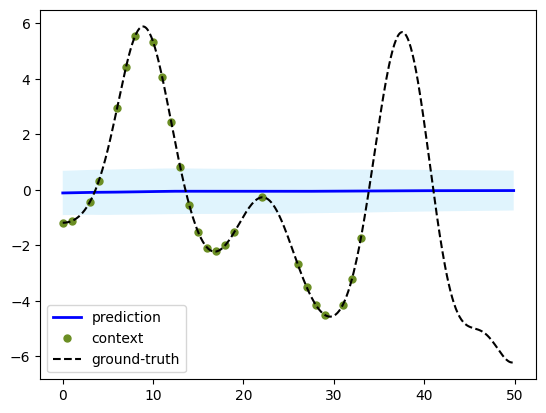

Epoch 500/50000, Loss: 429.5989


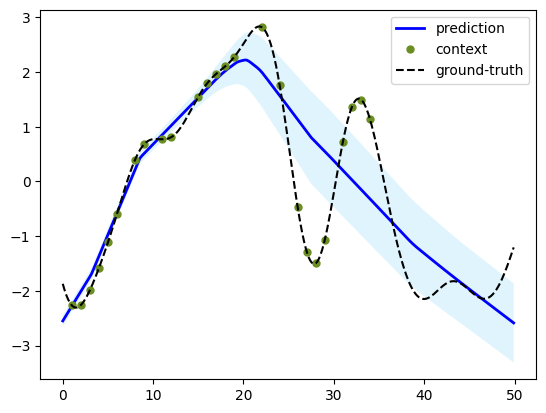

Epoch 1000/50000, Loss: 1058.3311


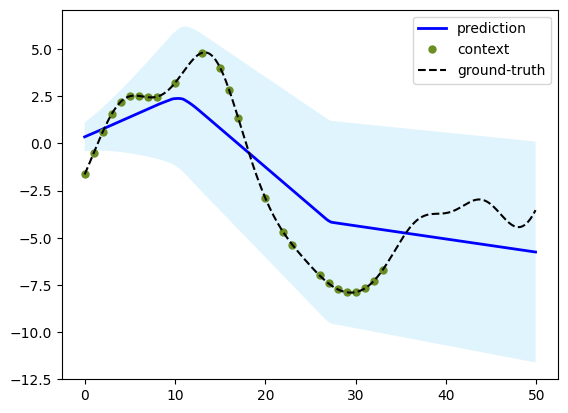

Epoch 1500/50000, Loss: 639.1723


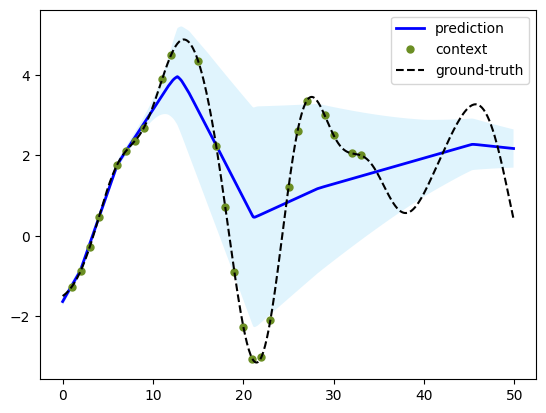

Epoch 2000/50000, Loss: 861.9408


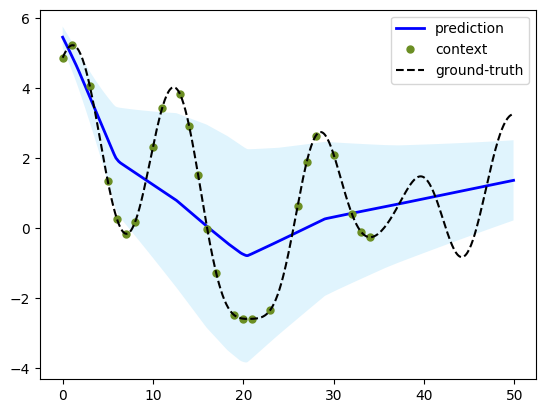

Epoch 2500/50000, Loss: 712.2936


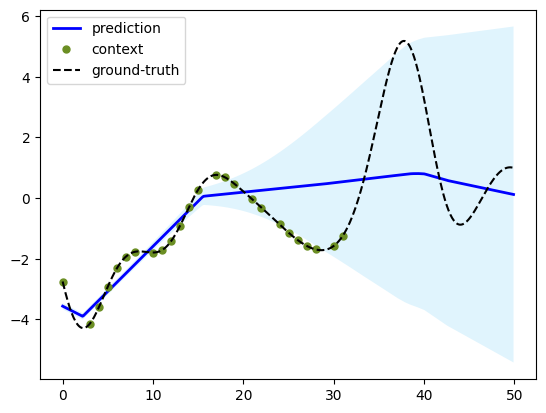

Epoch 3000/50000, Loss: 1017.9057


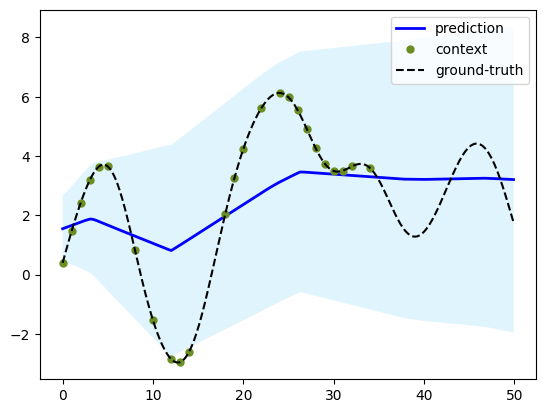

Epoch 3500/50000, Loss: 1136.6878


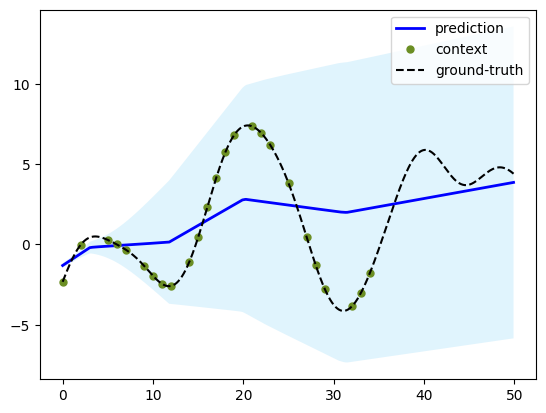

Epoch 4000/50000, Loss: 727.1801


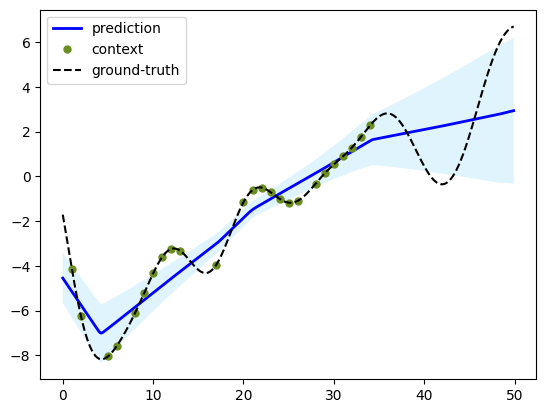

Epoch 4500/50000, Loss: 716.7758


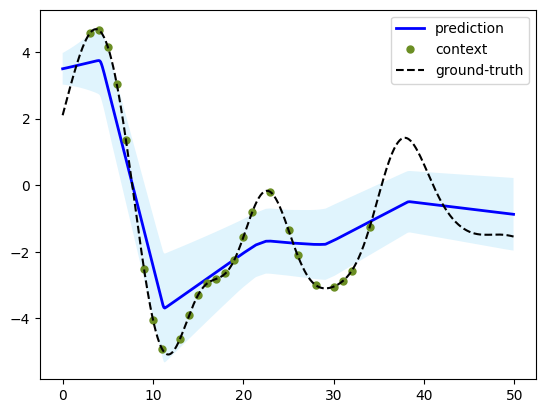

Epoch 5000/50000, Loss: 461.2070


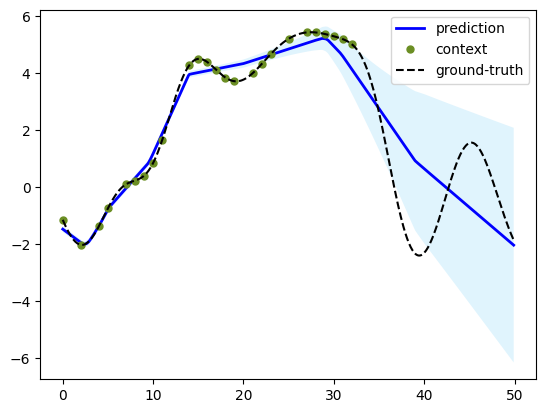

Epoch 5500/50000, Loss: 534.5267


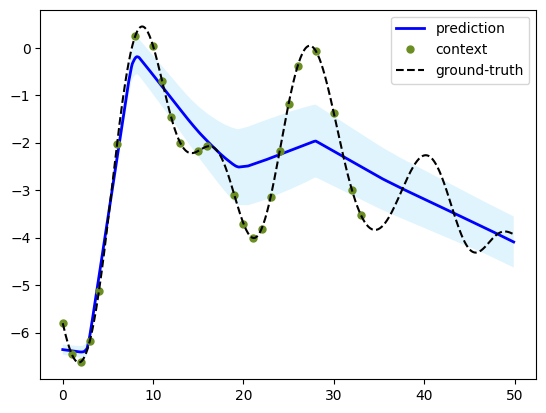

Epoch 6000/50000, Loss: 401.8484


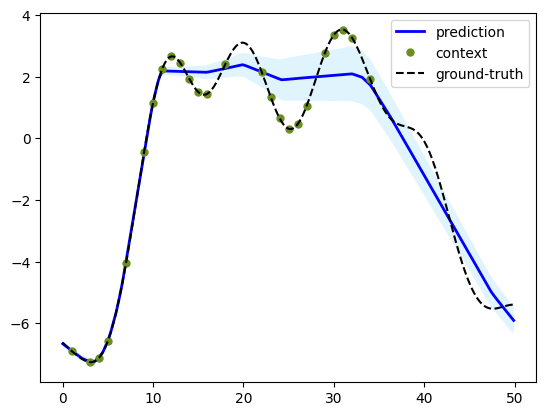

Epoch 6500/50000, Loss: 550.3524


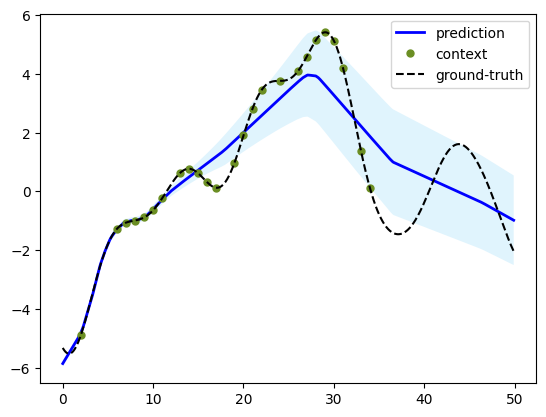

Epoch 7000/50000, Loss: 498.5944


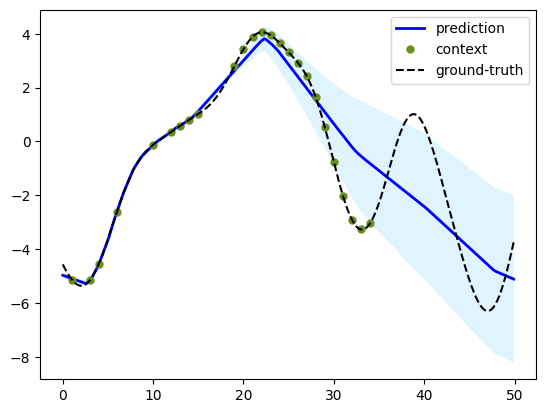

Epoch 7500/50000, Loss: 612.4141


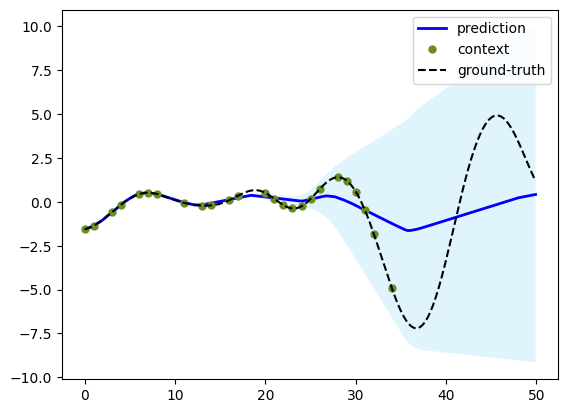

Epoch 8000/50000, Loss: 633.6724


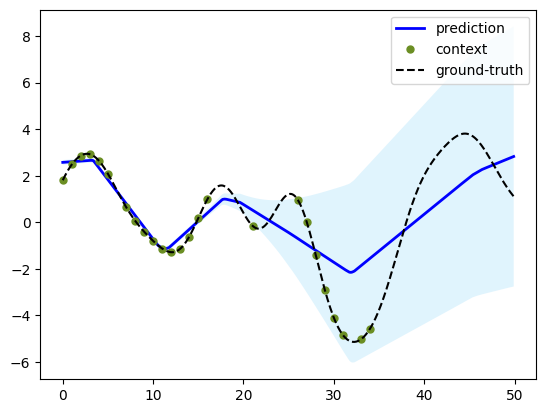

Epoch 8500/50000, Loss: 598.9197


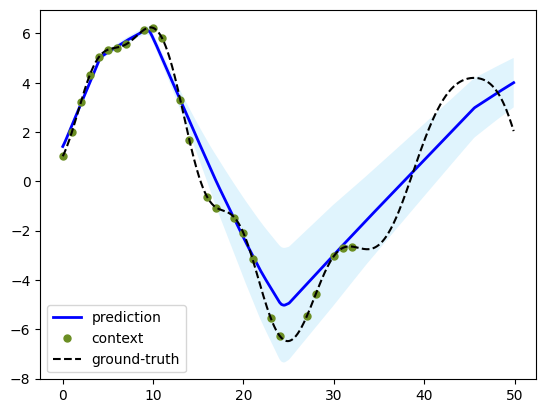

Epoch 9000/50000, Loss: 762.1535


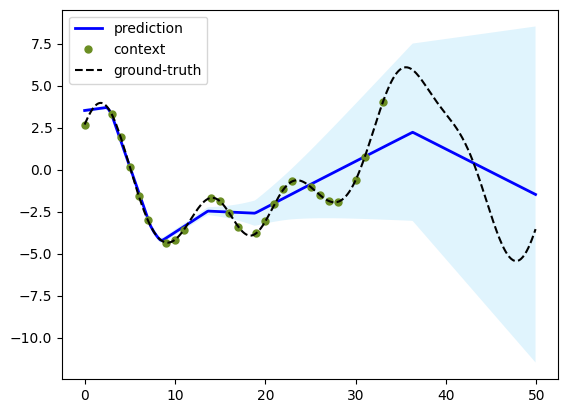

Epoch 9500/50000, Loss: 582.4102


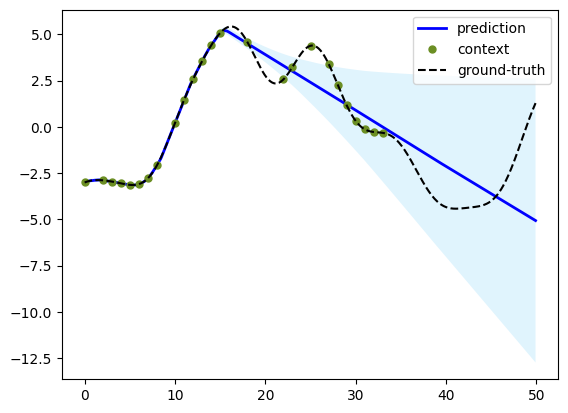

Epoch 10000/50000, Loss: 569.6895


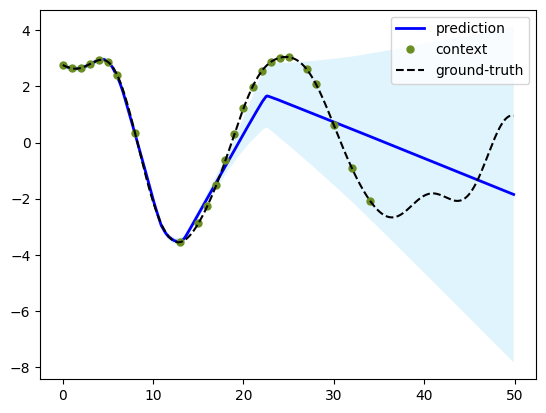

Epoch 10500/50000, Loss: 894.6175


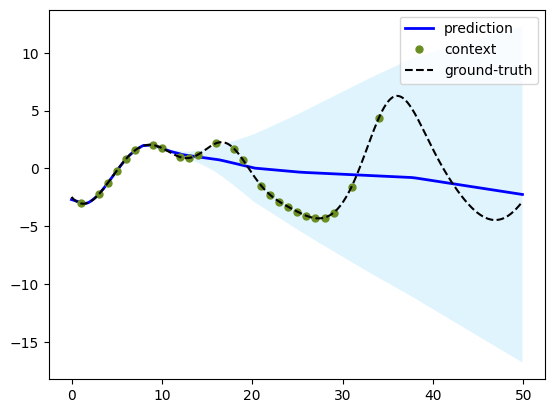

Epoch 11000/50000, Loss: 772.4847


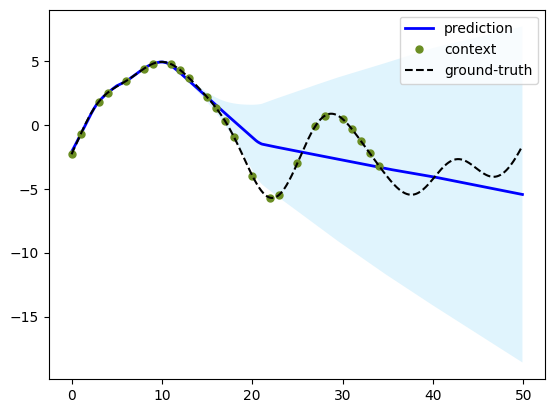

Epoch 11500/50000, Loss: 1114.5280


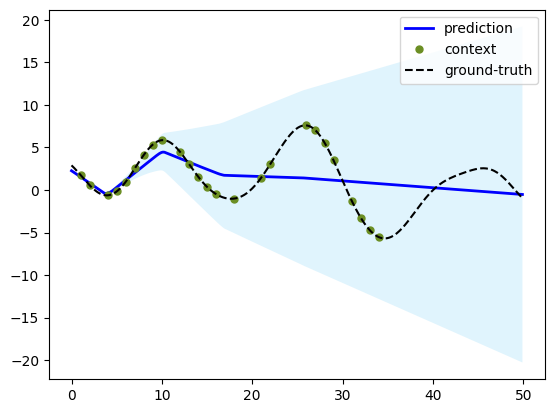

Epoch 12000/50000, Loss: 983.3942


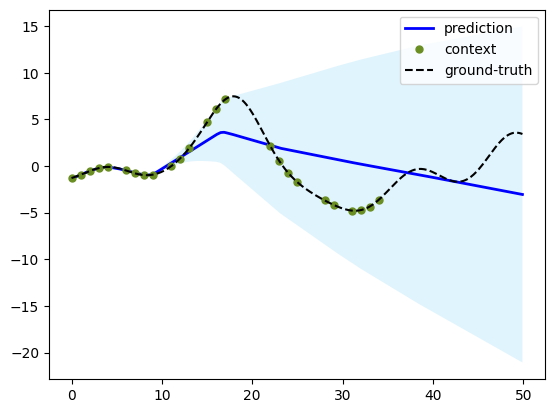

Epoch 12500/50000, Loss: 342.8594


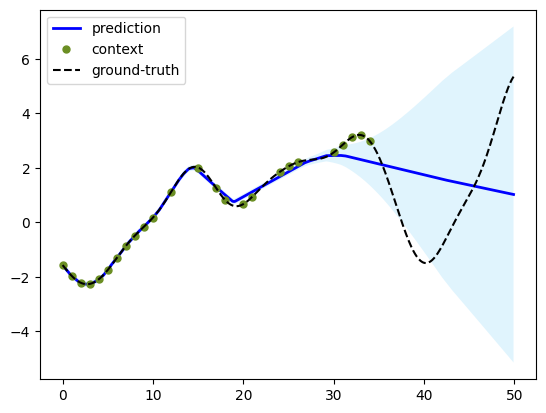

Epoch 13000/50000, Loss: 932.5637


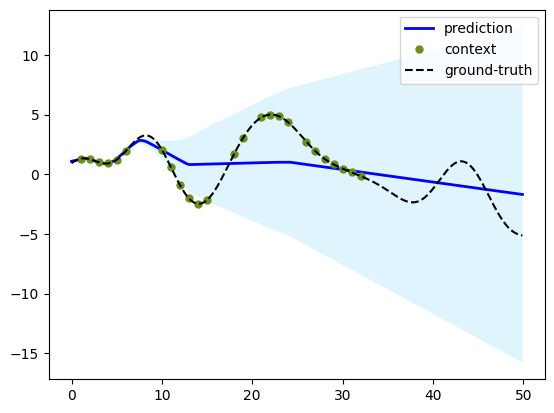

Epoch 13500/50000, Loss: 592.2817


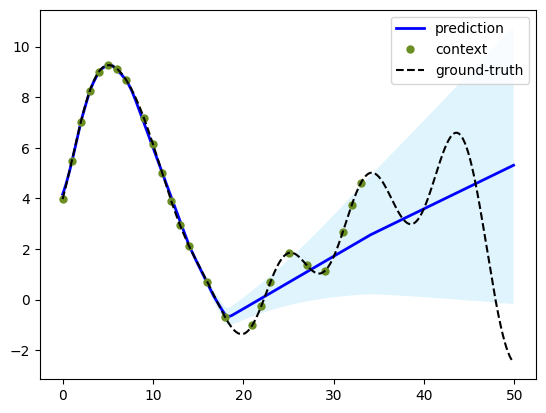

Epoch 14000/50000, Loss: 1290.4320


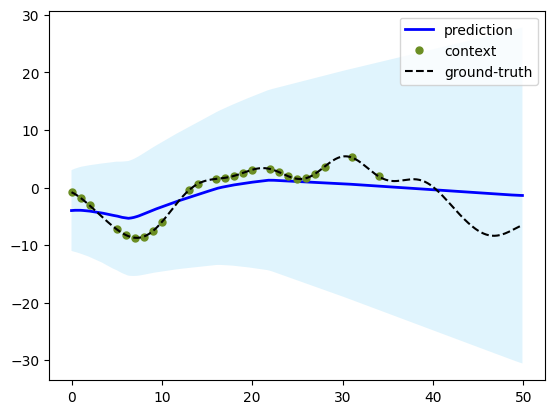

Epoch 14500/50000, Loss: 543.4925


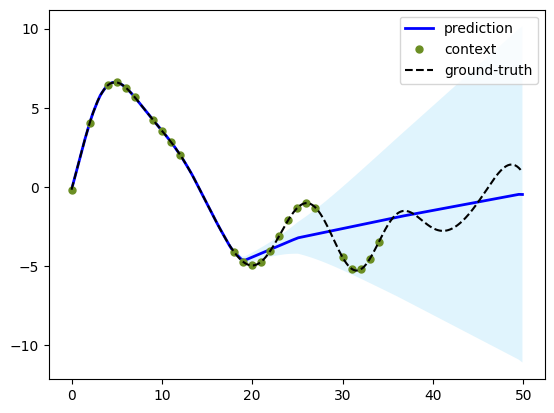

Epoch 15000/50000, Loss: 881.9726


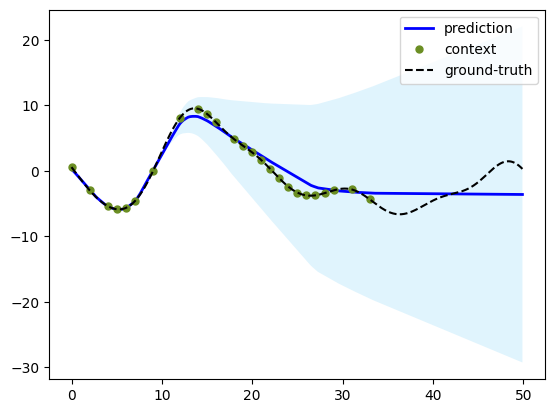

Epoch 15500/50000, Loss: 688.7802


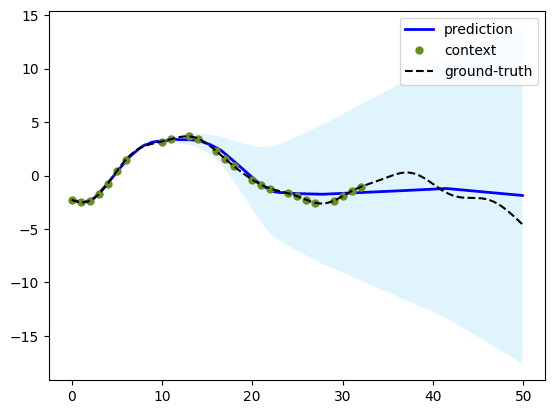

Epoch 16000/50000, Loss: 264.0224


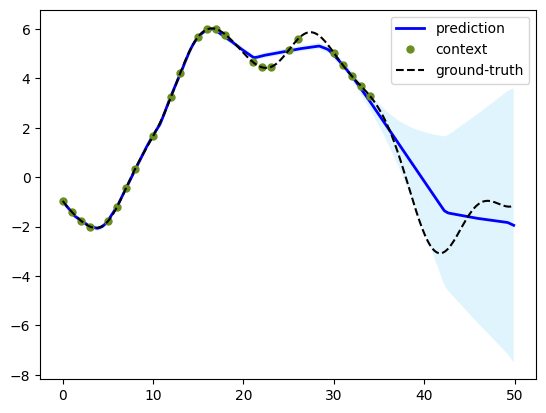

Epoch 16500/50000, Loss: 578.1996


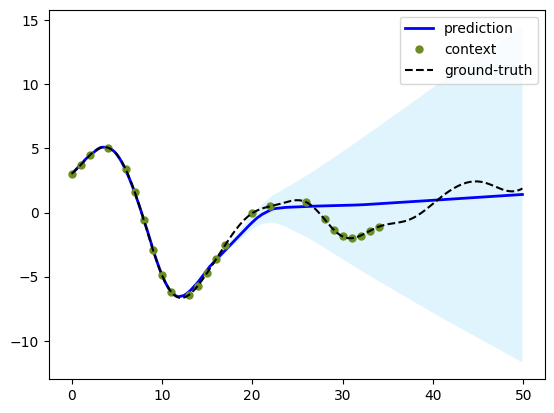

Epoch 17000/50000, Loss: 809.8239


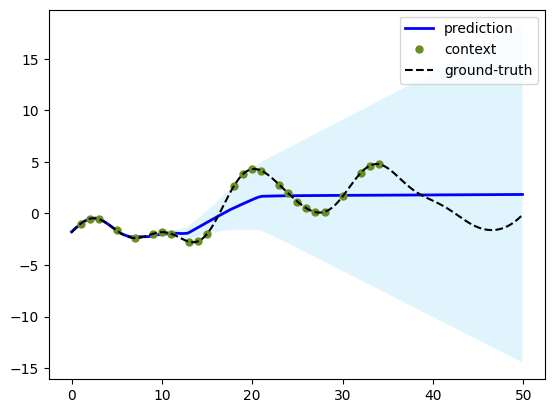

Epoch 17500/50000, Loss: 816.1403


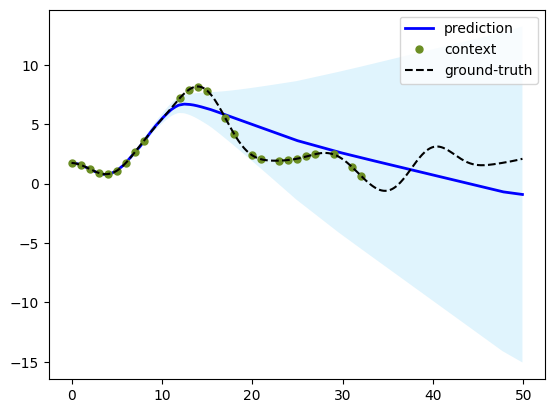

Epoch 18000/50000, Loss: 587.2756


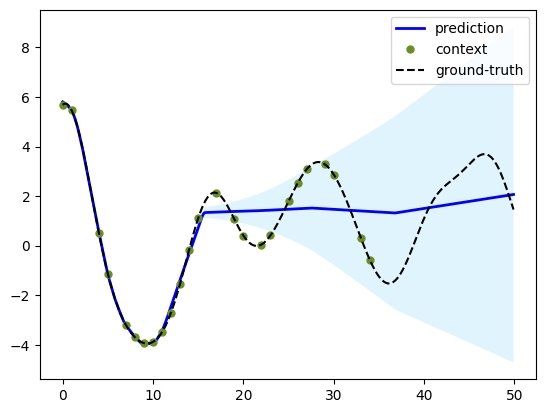

Epoch 18500/50000, Loss: 690.0332


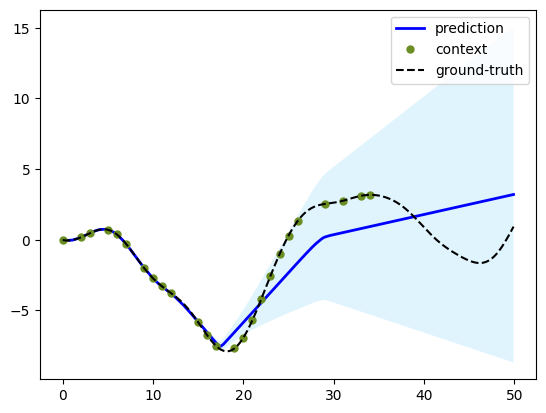

Epoch 19000/50000, Loss: 709.8085


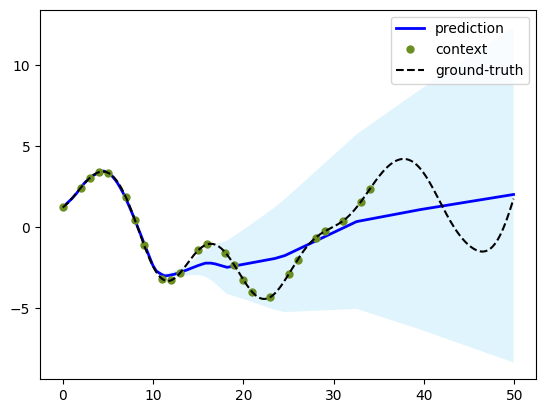

Epoch 19500/50000, Loss: 720.0761


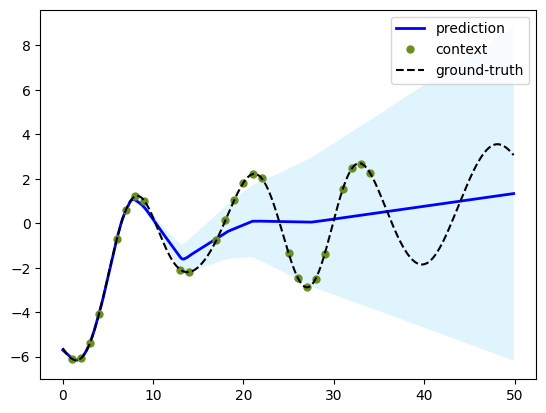

Epoch 20000/50000, Loss: 768.4767


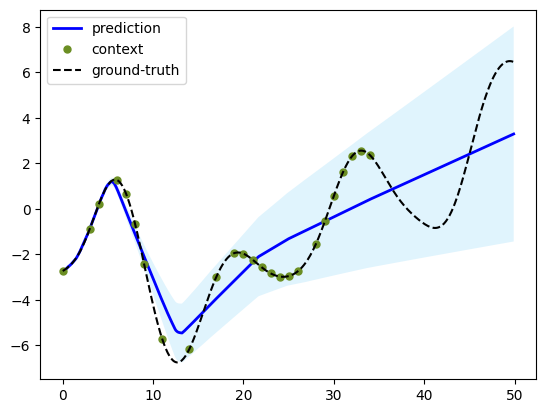

Epoch 20500/50000, Loss: 902.4353


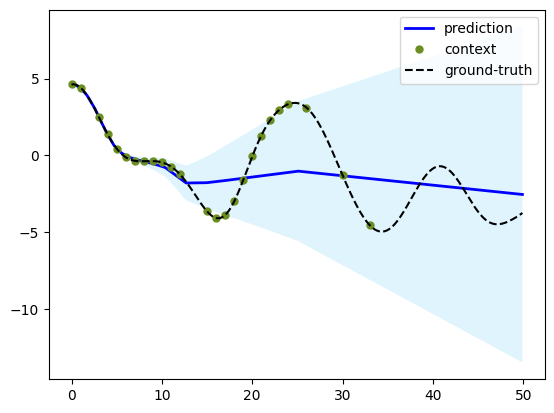

Epoch 21000/50000, Loss: 984.3638


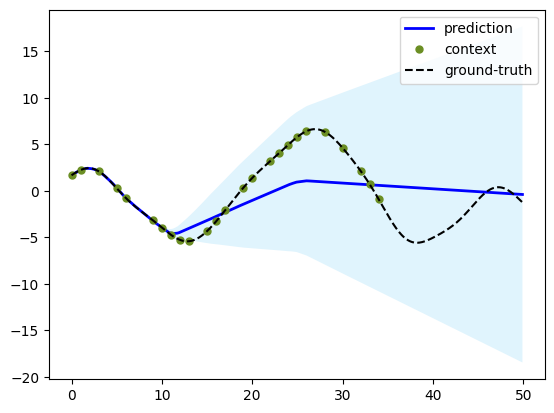

Epoch 21500/50000, Loss: 758.2766


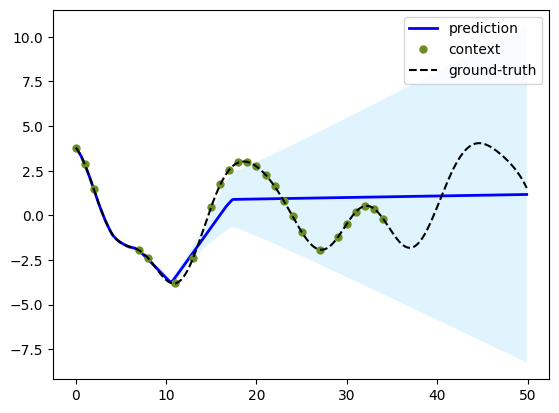

Epoch 22000/50000, Loss: 879.8199


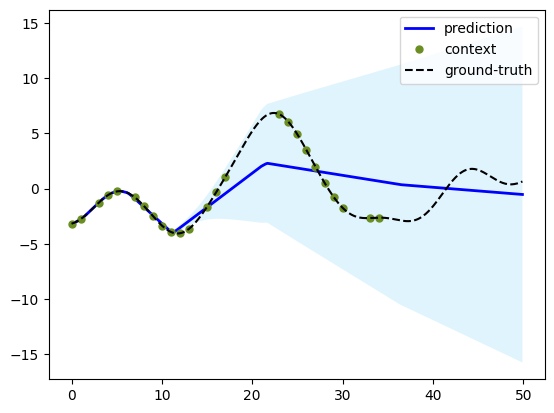

Epoch 22500/50000, Loss: 587.9402


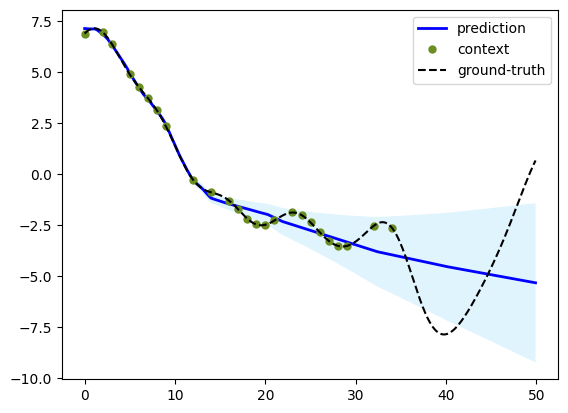

Epoch 23000/50000, Loss: 830.4266


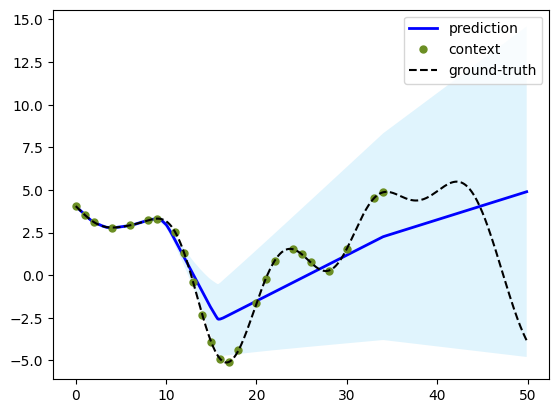

Epoch 23500/50000, Loss: 810.6218


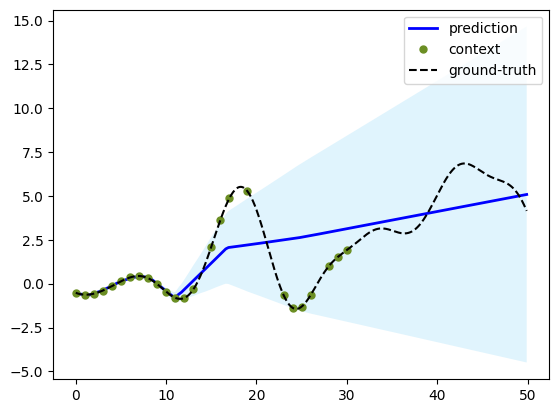

Epoch 24000/50000, Loss: 764.9870


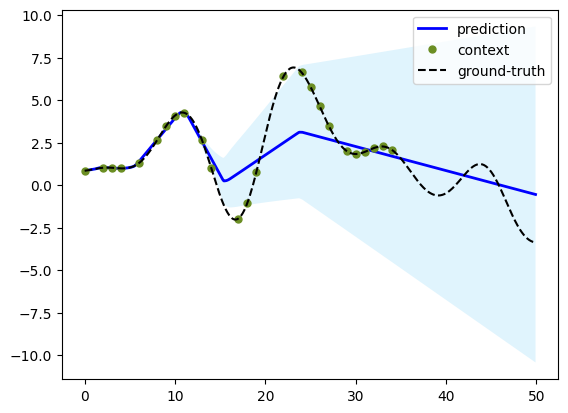

Epoch 24500/50000, Loss: 917.8308


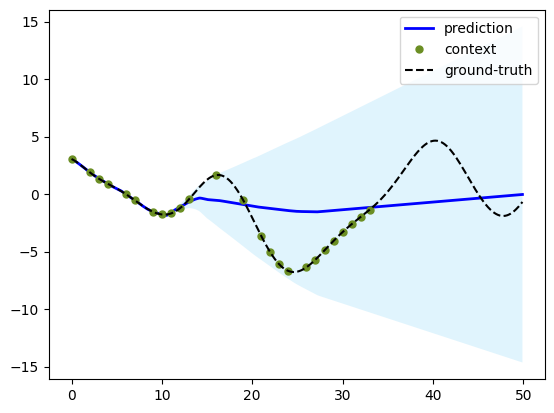

Epoch 25000/50000, Loss: 536.4910


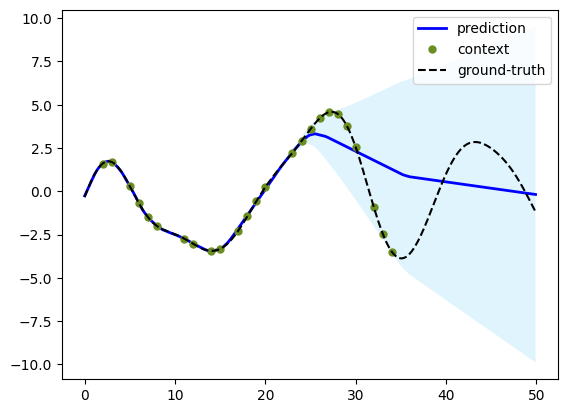

Epoch 25500/50000, Loss: 281.5837


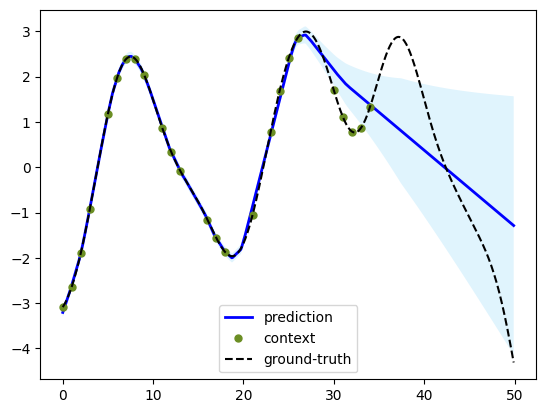

Epoch 26000/50000, Loss: 382.8386


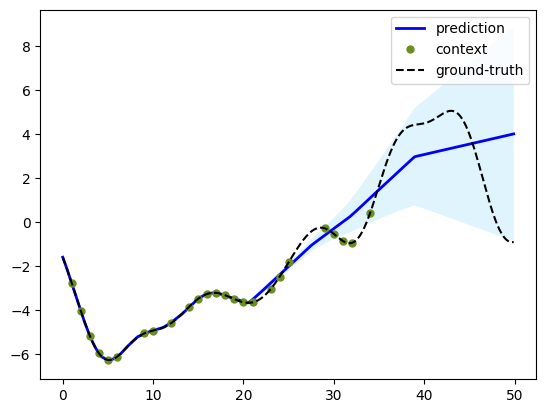

Epoch 26500/50000, Loss: 781.9488


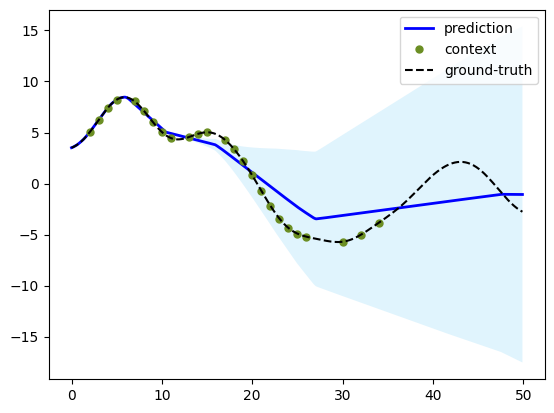

Epoch 27000/50000, Loss: 719.3516


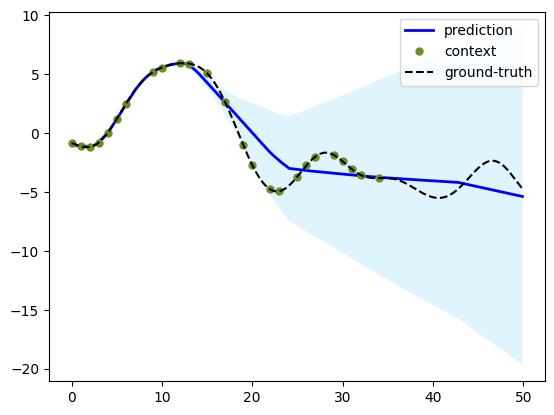

Epoch 27500/50000, Loss: 849.3999


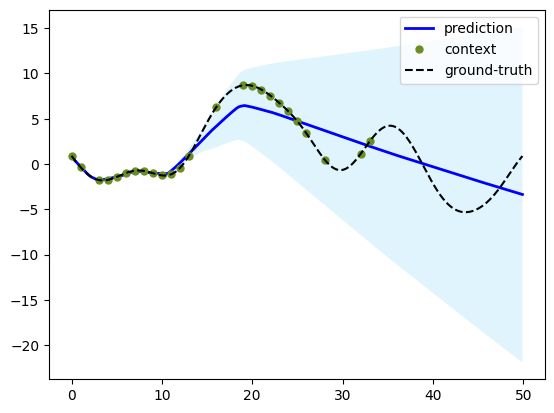

Epoch 28000/50000, Loss: 615.3391


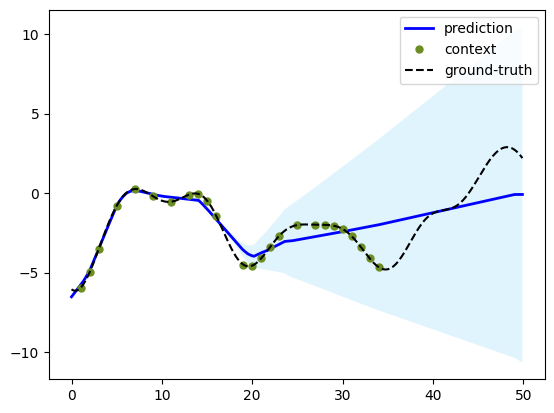

Epoch 28500/50000, Loss: 444.3214


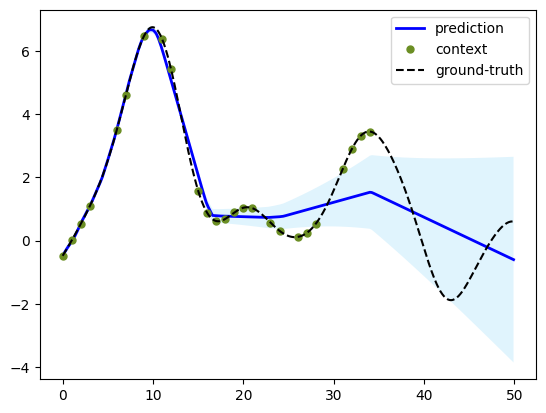

Epoch 29000/50000, Loss: 710.5515


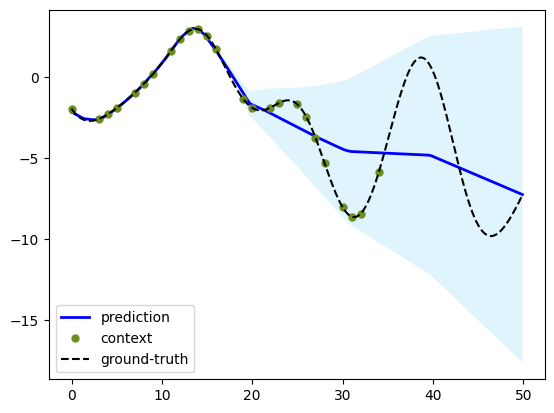

Epoch 29500/50000, Loss: 703.3158


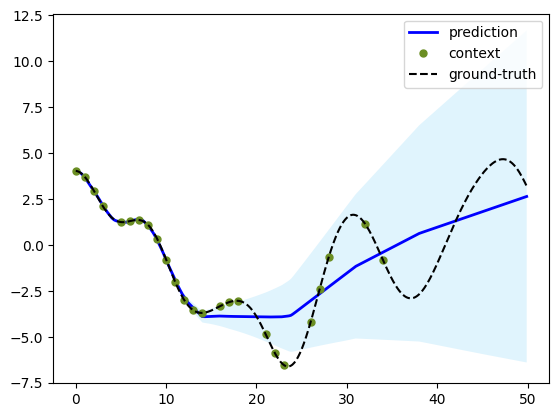

Epoch 30000/50000, Loss: 837.1988


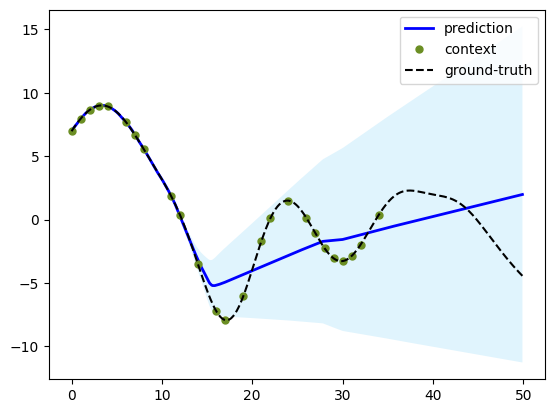

Epoch 30500/50000, Loss: 892.0996


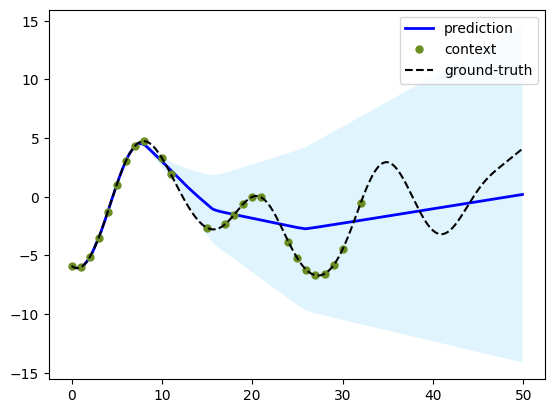

Epoch 31000/50000, Loss: 1073.7647


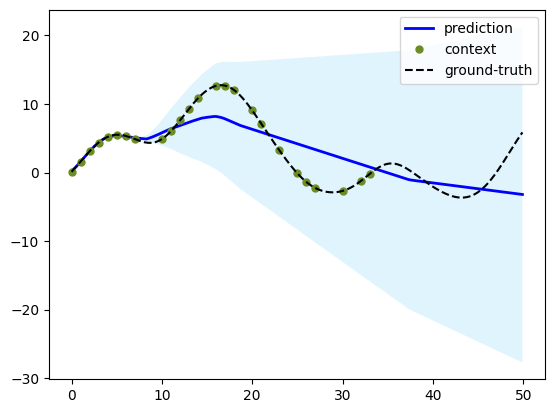

Epoch 31500/50000, Loss: 855.0047


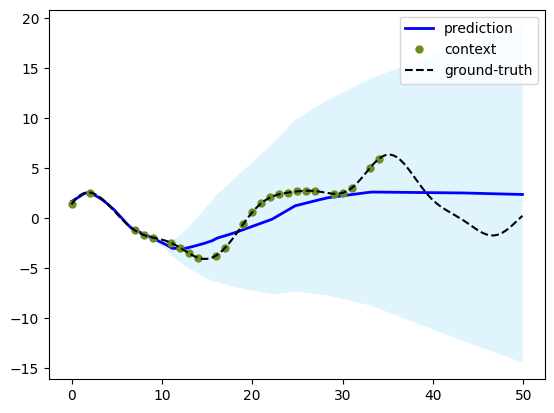

Epoch 32000/50000, Loss: 937.4408


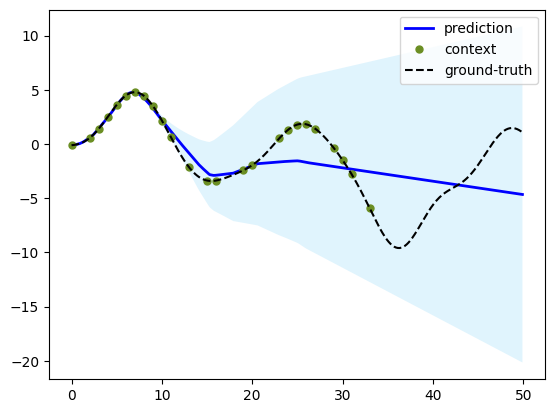

Epoch 32500/50000, Loss: 590.4790


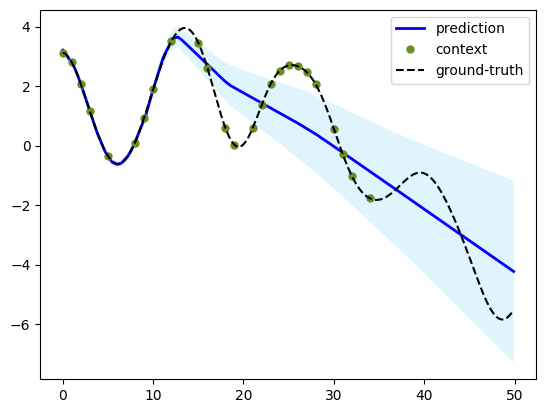

Epoch 33000/50000, Loss: 795.4309


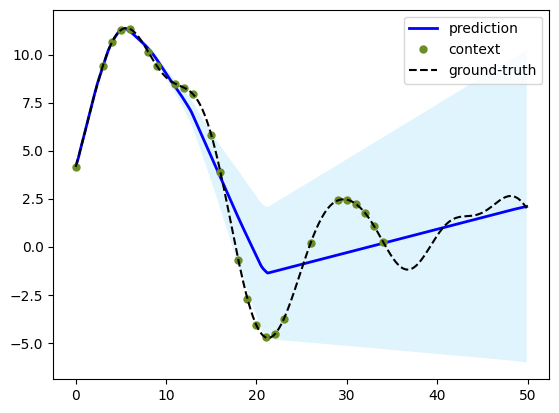

Epoch 33500/50000, Loss: 877.0186


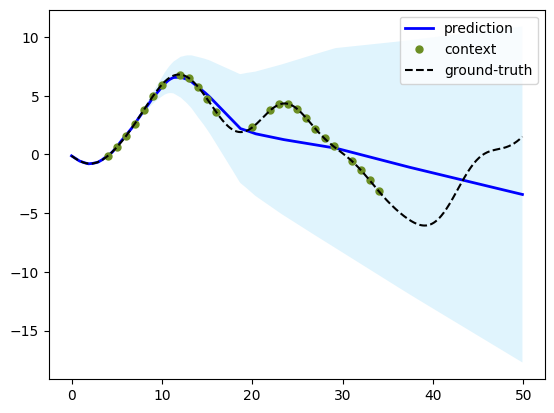

Epoch 34000/50000, Loss: 693.1493


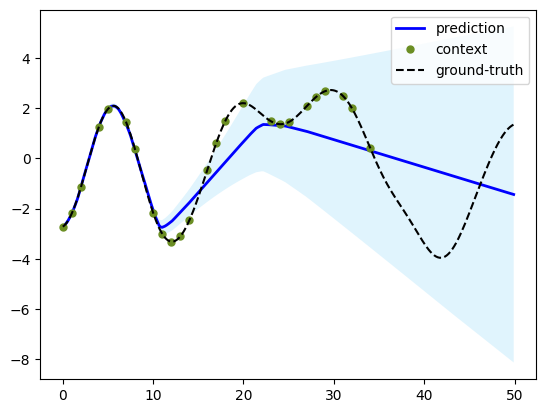

Epoch 34500/50000, Loss: 911.3767


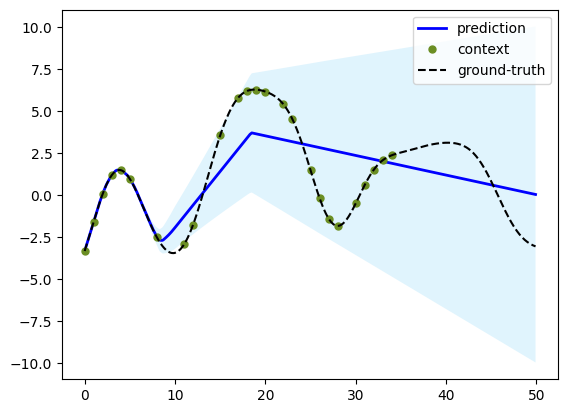

Epoch 35000/50000, Loss: 501.6443


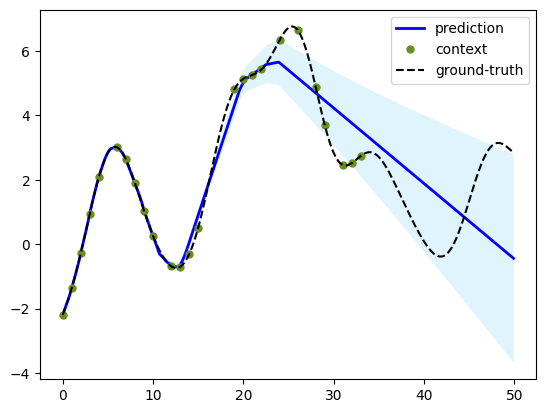

Epoch 35500/50000, Loss: 455.7177


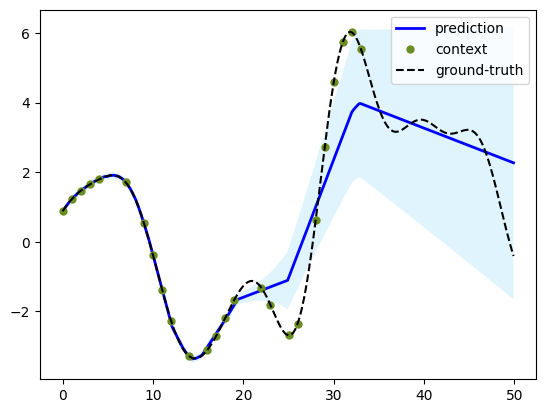

Epoch 36000/50000, Loss: 371.4550


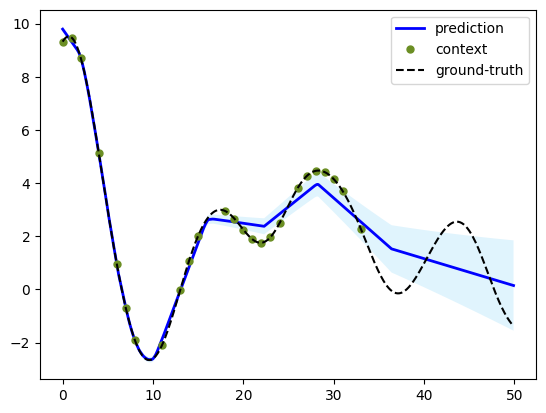

Epoch 36500/50000, Loss: 837.3532


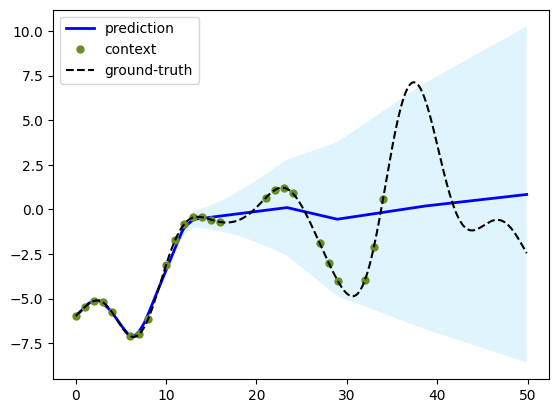

Epoch 37000/50000, Loss: 823.3419


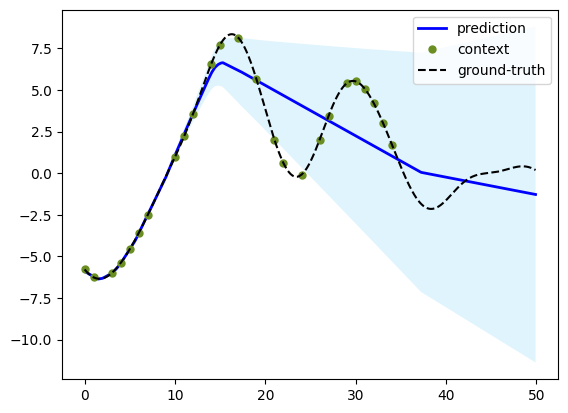

Epoch 37500/50000, Loss: 936.0859


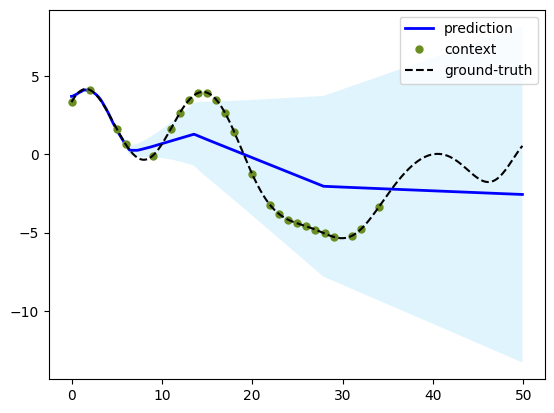

Epoch 38000/50000, Loss: 855.7686


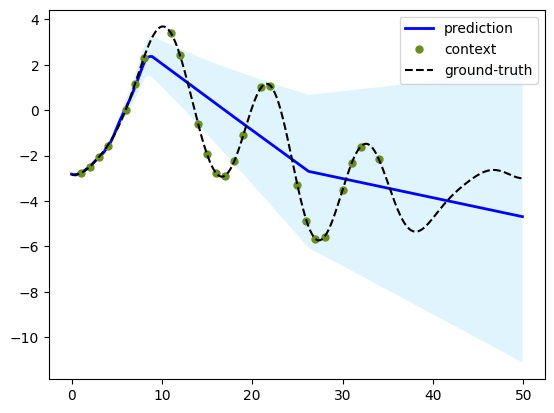

Epoch 38500/50000, Loss: 983.2031


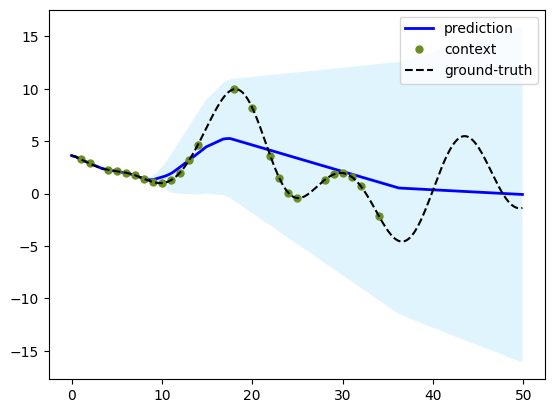

Epoch 39000/50000, Loss: 941.3668


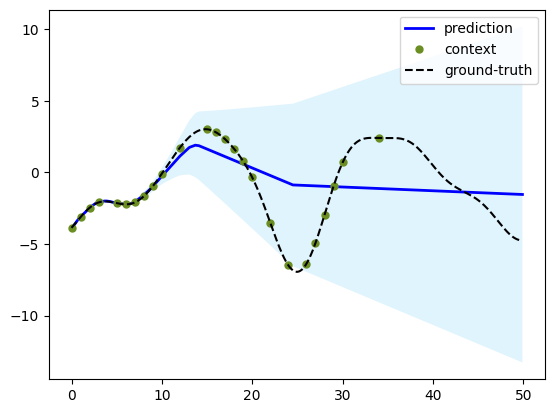

Epoch 39500/50000, Loss: 717.9419


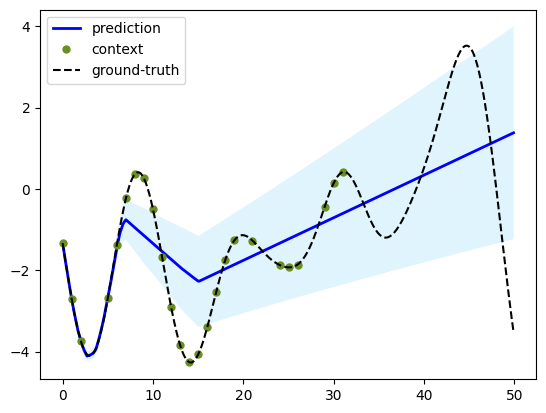

Epoch 40000/50000, Loss: 1097.8922


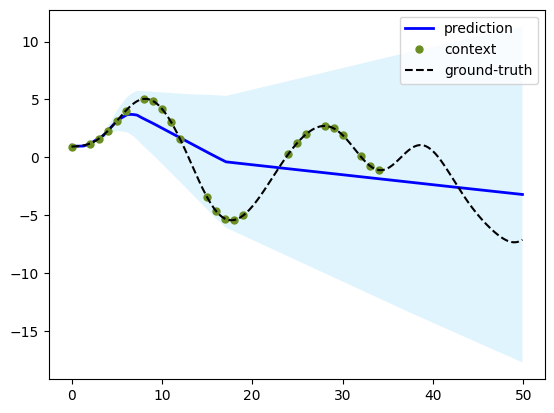

Epoch 40500/50000, Loss: 684.5861


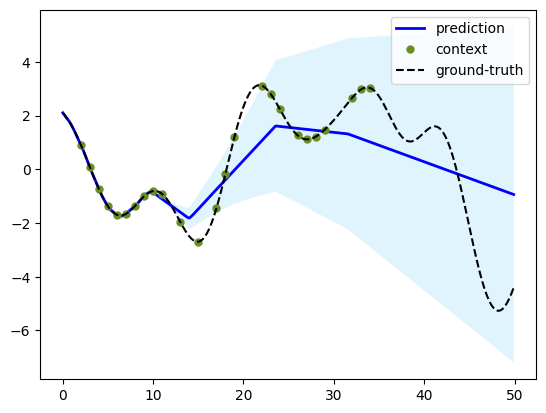

Epoch 41000/50000, Loss: 288.2919


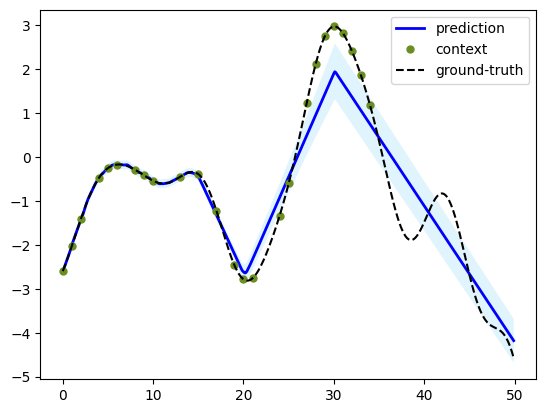

Epoch 41500/50000, Loss: 681.7399


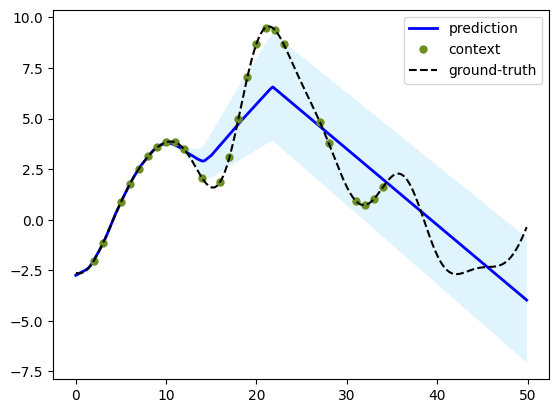

Epoch 42000/50000, Loss: 756.6810


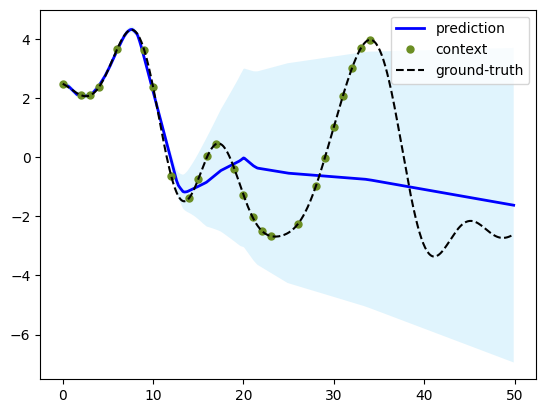

Epoch 42500/50000, Loss: 640.9945


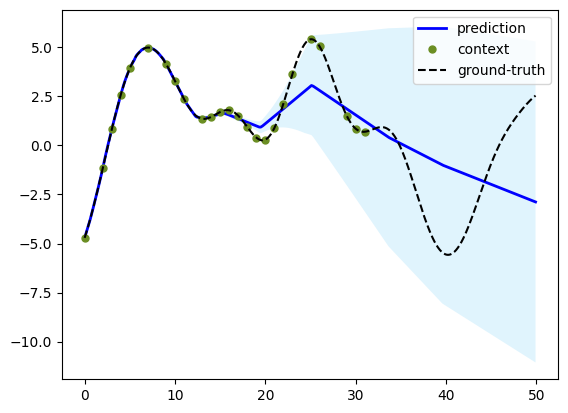

Epoch 43000/50000, Loss: 661.7418


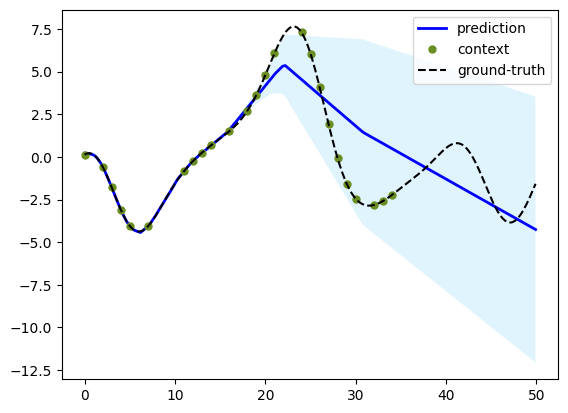

Epoch 43500/50000, Loss: 524.9602


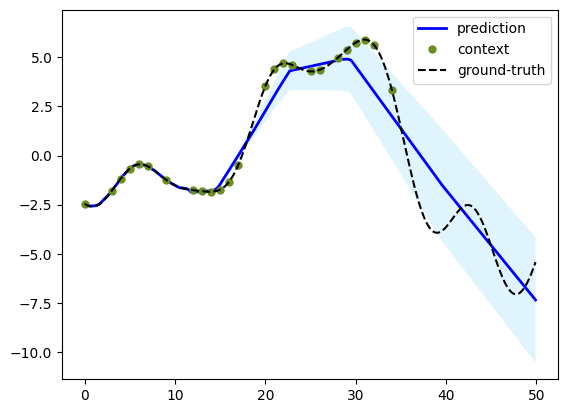

Epoch 44000/50000, Loss: 318.7220


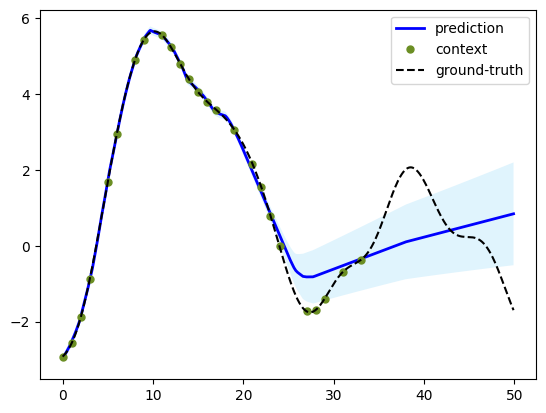

Epoch 44500/50000, Loss: 905.7733


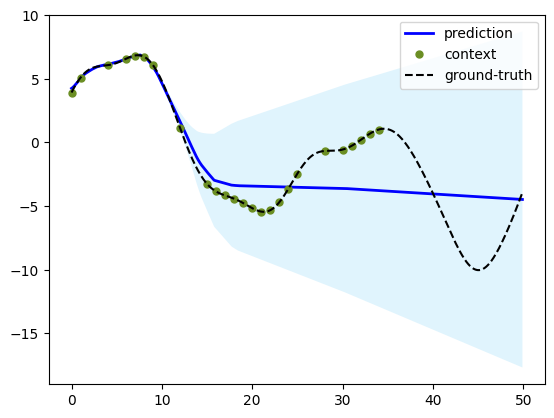

Epoch 45000/50000, Loss: 758.3688


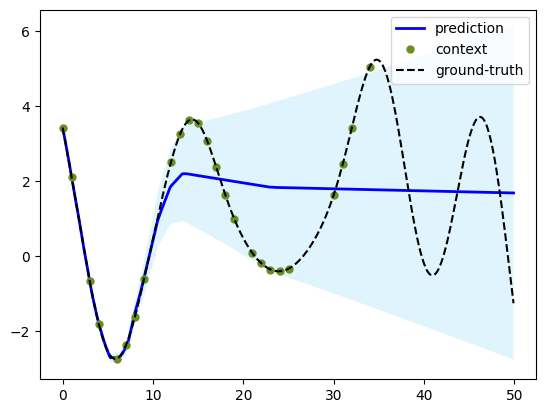

Epoch 45500/50000, Loss: 851.0216


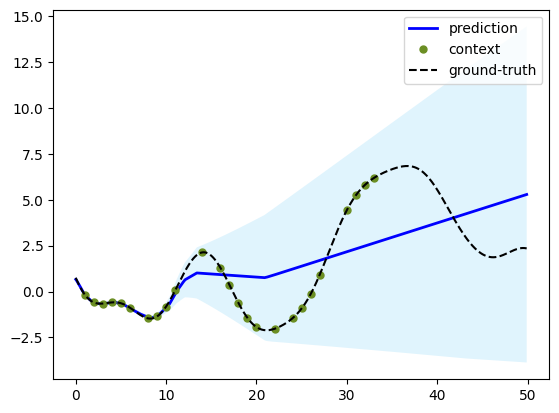

Epoch 46000/50000, Loss: 602.2892


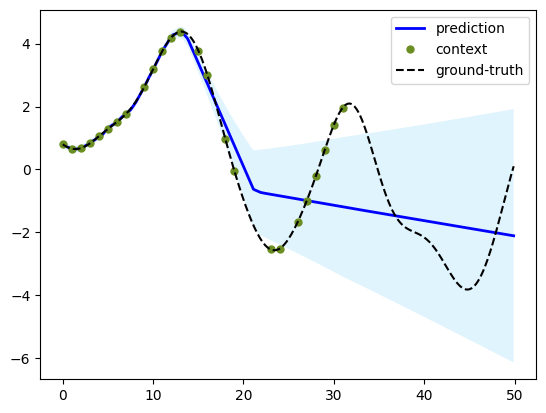

Epoch 46500/50000, Loss: 592.8262


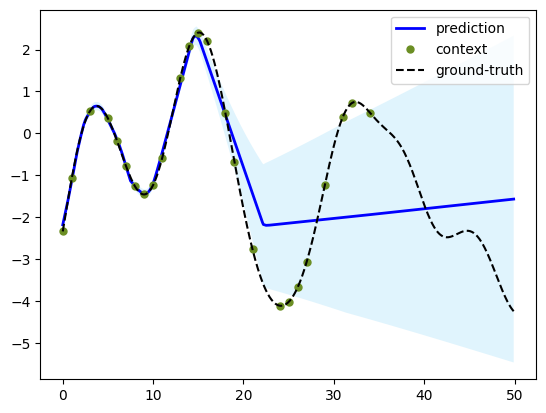

Epoch 47000/50000, Loss: 660.7922


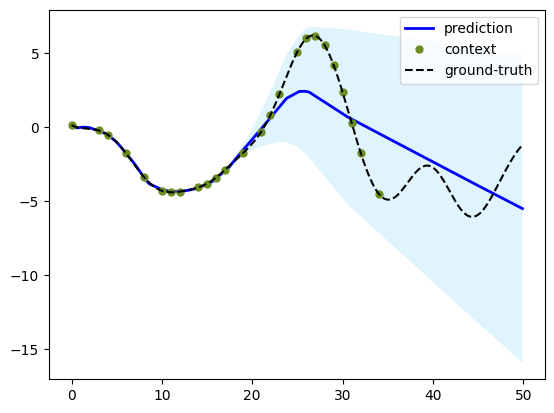

Epoch 47500/50000, Loss: 422.7881


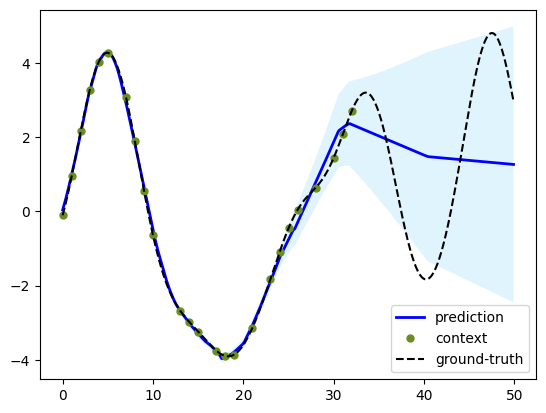

Epoch 48000/50000, Loss: 873.4945


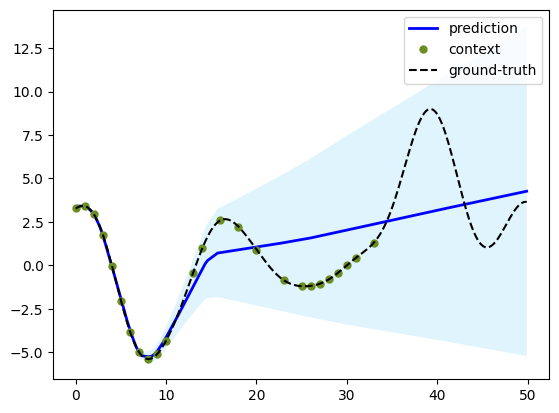

Epoch 48500/50000, Loss: 827.8917


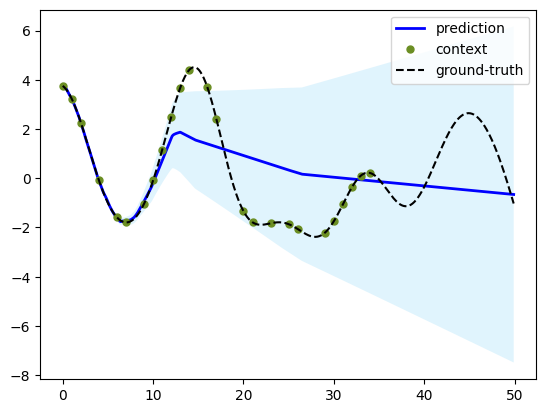

Epoch 49000/50000, Loss: 496.5277


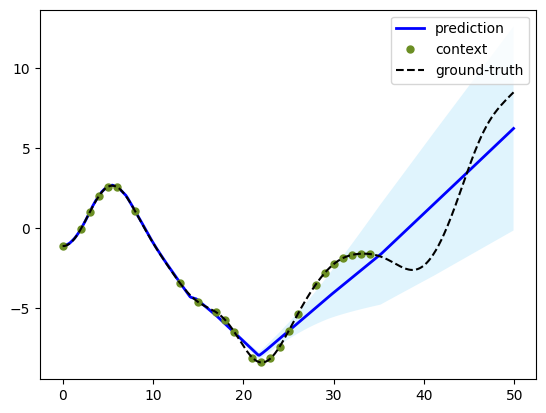

Epoch 49500/50000, Loss: 761.1144


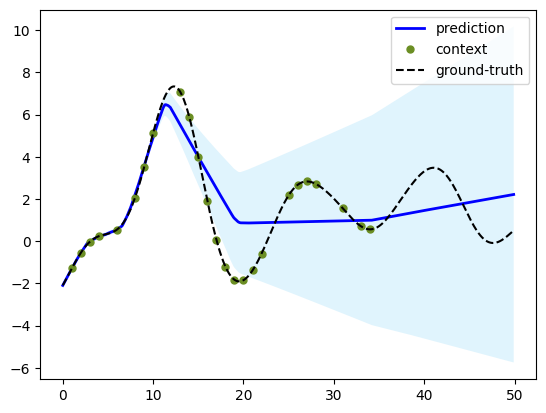

In [8]:
GP_generator = generate_GP_data( 10 , 4 , 0 , 50 ,25 , 15)
losses = [] 
for epoch in range(num_epochs):
    
    # sigma_scale , length_scale , L , U , num_context , num_target , upsample=10):
    context_x, context_y, target_x, target_y , ys , xs = GP_generator.give_data()
    loss , mu , sigma, logp ,ty = train(model, optimizer, context_x, context_y, target_x, target_y)
    losses.append(loss)

    
    if epoch % plot_after == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}")
        GP_generator = generate_GP_data( 10 , 4 , 0 , 50 ,25 , 15)
        plt.plot(target_x.cpu().numpy(), mu.cpu().numpy(), 'blue', linewidth=2)
#         plt.plot(target_x.cpu().numpy(), target_y.cpu().numpy(), 'green', linewidth=2)
        plt.plot(context_x.cpu().numpy(), context_y.cpu().numpy(), 'o' , color="olivedrab", markersize=5)
        plt.plot(xs.cpu().numpy(), ys.cpu().numpy(),  '--',color='black' ,  markersize=3)
        plt.fill_between(
        target_x.cpu().numpy()[:,0],
        mu.cpu().numpy() - sigma.cpu().numpy(),
        mu.cpu().numpy() + sigma.cpu().numpy(),
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)
        
        plt.legend(["prediction", "context" , "ground-truth"])
        plt.show()

# # Test the model
# context_x, context_y, target_x, target_y = generate_data(num_context, num_target)
# target_y_pred = test(model, context_x, context_y, target_x)


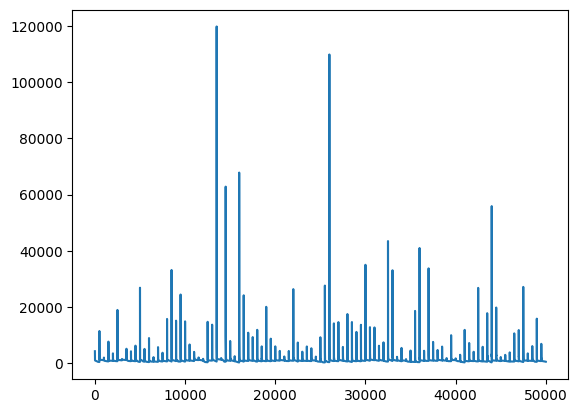

In [9]:
plt.plot(losses)